In [1]:
from pandas import Series
from pandas import Period
Series()

Series([], dtype: float64)

In [2]:
def create_multiplayer_hr_dataframe(players_dataframes):
    return pd.concat(players_dataframes, axis=1).fillna(value=0).resample('D').sum()

def create_multiplayer_hr_total_dataframe(players_dataframes):
    return pd.concat(players_dataframes, axis=1).fillna(method='ffill').fillna(value=0).resample('D').last().fillna(method='ffill')

In [3]:
from __future__ import print_function
from datetime import datetime
import mlbgame
import mlbgame.update

from pandas import DataFrame, Series
import pandas as pd 

#configure the set-up. Not well factored
year = 2016

mlbgame.update.run(start="04-01-2016")

season_start_date = datetime(year, 04, 04)
today_date = datetime.today()


# Crappy way to map the month around
class Month:
    def __init__(self, name, id):
        self.name = name
        self.id = id

months = [Month("April", 4), Month("May", 5), Month("June", 6), Month("July", 7),
Month("August", 8), Month("September", 9)]

months_dict = {}
for month in months:
    months_dict[month.id] = month

class Player:
    def __init__(self, first_name, last_name, id):
        self.first_name = first_name
        self.last_name = last_name
        self.id = id
        self.hrs = [0,0,0,0,0,0] #One for each month of the game
        self.hr_total = 0
        self.hr_series = Series()
        self.hr_total_series = Series()

    def __str__(self):
        return str.format('{0} : {1}', self.id, self.last_name)

    def __repr__(self):
        return self.__str__()

    def add_hrs(self, count, date):
        
        
        if(self.hr_series.last_valid_index() == date ):
            print('same day', self.hr_series.last_valid_index(), date, self.name(), count, self.hr_series[date] )
            #This data seems to be doubling values right now, need to look into this
            #self.hr_series[date] = count + self.hr_series[date]
        else:
            
            self.hr_total += count
            self.hr_total_series[date] = self.hr_series.fillna(value=0).sum() + count
            self.hr_series[date] = count


    def name(self):
        return self.first_name + " " + self.last_name

    def get_player_hr_dataframe(self):
        return self.hr_series.to_frame(self.name())

    def get_player_hr_total_dataframe(self):
        return self.hr_total_series.to_frame(self.name())

players_dict = {}

#Hand mapped in these players -  ID comes from mlb.com player ID
#No Cannonical naming in a way I could trust to write code to match based upon name.
#This is obviously annoying for the future. Probably can build the data of all players
#in a programatic way in the future (create a CSV and map that in here rather 
#than do it by hand)
players = [Player("Bryce", "Harper", 547180),
Player("Mookie", "Betts", 605141),
Player("Miguel", "Sano", 593934),
Player("Randal", "Grichuk", 545341),
Player("George", "Springer", 543807),
Player("Rougned", "Odor", 596059),
Player("Jonathan", "Schoop", 570731),
Player("Giancarlo", "Stanton", 519317),
Player("Prince", "Fielder", 425902),
Player("Mark", "Trumbo", 444432),
Player("Carlos", "Correa", 621043),
Player("Miguel", "Cabrera", 408234),
Player("Kyle", "Schwarber", 656941),
Player("Maikel", "Franco", 596748),
Player("Kris", "Bryant", 592178),
Player("Nick", "Castellanos", 592206),
Player("Adam", "Jones", 430945),
Player("Ryan", "Zimmerman", 475582),
Player("Addison", "Russell", 608365)
]


for player in players:
    players_dict[player.id] = player



class User:
    def __init__(self, name, playerIds, players_dict):
        self.name = name
        self.playerIds = playerIds
        self.players = []
        for p in self.playerIds:
            self.players.append(players_dict[p])

            
    def players_hr_dataframe(self):
        dataframes = map(lambda p : p.get_player_hr_dataframe(), self.players)
        return create_multiplayer_hr_dataframe(dataframes)

    def players_hr_total_dataframe(self):
        dataframes = map(lambda p : p.get_player_hr_total_dataframe(), self.players)
        return create_multiplayer_hr_total_dataframe(dataframes)


#TODO: Take this mapping and make it read from a text file
users = [User("Dave", [519317, 425902, 444432, 621043, 408234, 656941, 596748], players_dict),
User("Craig", [547180, 605141, 593934, 545341, 543807, 596059, 570731], players_dict),
User("Brian", [519317, 592178, 425902, 593934, 408234, 656941, 592206], players_dict),
User("Jason", [519317, 430945, 592178, 593934, 475582, 656941, 608365], players_dict)]



for m in months:
    month = mlbgame.games(year, m.id)

    for games in month:
        for game in games:
            #Only games in the season (pre-season games will be included without this)
            #Also don't try to pull games that have not been played yet as the record
            #will exist but the call to get the stats will fail
            if game.date > season_start_date: # and game.date < today_date:
                #Try check is here because postponed games will still come through
                #Need to figure out if there is a way to deal with this actively rather than passively
                try:
                    stats = mlbgame.player_stats(game.game_id)
                    game_stats_all = mlbgame.combine_stats(stats)
                    for game_stats in game_stats_all:

                        if hasattr(game_stats, 'hr') and game_stats.id in players_dict:
                            p = players_dict[game_stats.id]
                            p.add_hrs(game_stats.hr, Period(game.date, freq='H'))
                            p.hrs[m.id - 4] += game_stats.hr #-4 to map April to 0 index this is a shitty way to do this

                except ValueError as e:
                    print("Game not found:", game.game_id, e)

# For debugging purposes, print out player totals
#for player in players:
#    print(player.first_name, player.last_name, player.hrs, "Total:", player.)


print()

def user_month_total(user, month):
    total = 0
    for p in user.playerIds:
        player = players_dict[p]
        total += player.hrs[month]
    return total

def user_total(user):
    total = 0
    for p in user.playerIds:
        player = players_dict[p]
        total += sum(player.hrs.fillna(value=0))
    return total




Checking local data...
Complete.
Game not found: 2016_04_04_houmlb_nyamlb_1 Could not find a game with that id.
Game not found: 2016_04_04_bosmlb_clemlb_1 Could not find a game with that id.
Game not found: 2016_04_09_miamlb_wasmlb_1 Could not find a game with that id.
Game not found: 2016_04_10_nyamlb_detmlb_1 Could not find a game with that id.
Game not found: 2016_04_17_balmlb_texmlb_1 Could not find a game with that id.
Game not found: 2016_04_27_milmlb_chnmlb_1 Could not find a game with that id.
Game not found: 2016_04_28_pitmlb_colmlb_1 Could not find a game with that id.
Game not found: 2016_04_30_atlmlb_chnmlb_1 Could not find a game with that id.
Game not found: 2016_05_16_bosmlb_kcamlb_1 Could not find a game with that id.
Game not found: 2016_05_26_chamlb_kcamlb_1 Could not find a game with that id.
Game not found: 2016_09_25_atlmlb_miamlb_1 Could not find a game with that id.



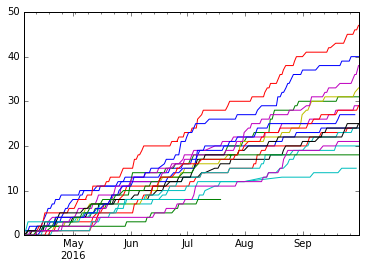

In [4]:
import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting
%matplotlib inline

for player in players:
    player.hr_total_series.plot()

In [5]:
player_hr_total_dfs = map(lambda p : p.hr_total_series.to_frame(p.name()), players)
player_hr_dfs = map(lambda p : p.get_player_hr_dataframe(), players)

In [6]:
player_hr_total_df = create_multiplayer_hr_total_dataframe(player_hr_total_dfs)
player_hr_total_df

,Bryce Harper,Mookie Betts,Miguel Sano,Randal Grichuk,George Springer,Rougned Odor,Jonathan Schoop,Giancarlo Stanton,Prince Fielder,Mark Trumbo,Carlos Correa,Miguel Cabrera,Kyle Schwarber,Maikel Franco,Kris Bryant,Nick Castellanos,Adam Jones,Ryan Zimmerman,Addison Russell
2016-04-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-06,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-04-07,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-04-08,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-04-09,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-04-10,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-04-11,2.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2016-04-12,2.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2016-04-13,2.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0


In [7]:
player_hr_df = create_multiplayer_hr_dataframe(player_hr_dfs)
player_hr_df

,Bryce Harper,Mookie Betts,Miguel Sano,Randal Grichuk,George Springer,Rougned Odor,Jonathan Schoop,Giancarlo Stanton,Prince Fielder,Mark Trumbo,Carlos Correa,Miguel Cabrera,Kyle Schwarber,Maikel Franco,Kris Bryant,Nick Castellanos,Adam Jones,Ryan Zimmerman,Addison Russell
2016-04-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-04-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-08,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2016-04-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [8]:
filled_player_hr_total_df = player_hr_df.fillna(method='ffill').fillna(value=0)
filled_player_hr_total_df

,Bryce Harper,Mookie Betts,Miguel Sano,Randal Grichuk,George Springer,Rougned Odor,Jonathan Schoop,Giancarlo Stanton,Prince Fielder,Mark Trumbo,Carlos Correa,Miguel Cabrera,Kyle Schwarber,Maikel Franco,Kris Bryant,Nick Castellanos,Adam Jones,Ryan Zimmerman,Addison Russell
2016-04-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-04-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-08,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2016-04-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [9]:
filled_player_hr_total_df.tail(5)

,Bryce Harper,Mookie Betts,Miguel Sano,Randal Grichuk,George Springer,Rougned Odor,Jonathan Schoop,Giancarlo Stanton,Prince Fielder,Mark Trumbo,Carlos Correa,Miguel Cabrera,Kyle Schwarber,Maikel Franco,Kris Bryant,Nick Castellanos,Adam Jones,Ryan Zimmerman,Addison Russell
2016-09-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-09-27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-28,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-30,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
player_hr_df.resample('M').sum().transpose().sort_values('2016-04', ascending=False)

,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09
Bryce Harper,9.0,4.0,3.0,4.0,3.0,1.0
Giancarlo Stanton,8.0,4.0,3.0,7.0,3.0,2.0
Mark Trumbo,6.0,9.0,8.0,7.0,10.0,7.0
Maikel Franco,5.0,3.0,5.0,6.0,3.0,3.0
George Springer,4.0,8.0,5.0,5.0,3.0,4.0
Jonathan Schoop,4.0,4.0,5.0,4.0,4.0,4.0
Mookie Betts,4.0,8.0,4.0,5.0,9.0,1.0
Miguel Cabrera,4.0,8.0,6.0,5.0,5.0,10.0
Kris Bryant,4.0,7.0,11.0,5.0,10.0,3.0
Randal Grichuk,3.0,4.0,1.0,4.0,7.0,5.0


In [11]:
user_player_hrs = []
for user in users:
    user_player_hrs.append(user.players_hr_dataframe().transpose().sum())

hr_frame = pd.concat(user_player_hrs, axis=1).rename(columns={0:"Dave", 1:"Craig", 2: "Brian", 3:"Jason"})


In [12]:
user_player_hrs_totals = []
for user in users:
    user_player_hrs_totals.append(user.players_hr_total_dataframe().transpose().sum())

user_player_hrs_totals

[2016-04-04      0.0
 2016-04-05      2.0
 2016-04-06      6.0
 2016-04-07      6.0
 2016-04-08      7.0
 2016-04-09      7.0
 2016-04-10      7.0
 2016-04-11      9.0
 2016-04-12     10.0
 2016-04-13     11.0
 2016-04-14     12.0
 2016-04-15     14.0
 2016-04-16     14.0
 2016-04-17     14.0
 2016-04-18     15.0
 2016-04-19     16.0
 2016-04-20     16.0
 2016-04-21     16.0
 2016-04-22     18.0
 2016-04-23     19.0
 2016-04-24     20.0
 2016-04-25     23.0
 2016-04-26     24.0
 2016-04-27     24.0
 2016-04-28     26.0
 2016-04-29     27.0
 2016-04-30     28.0
 2016-05-01     28.0
 2016-05-02     28.0
 2016-05-03     30.0
               ...  
 2016-09-01    142.0
 2016-09-02    144.0
 2016-09-03    144.0
 2016-09-04    144.0
 2016-09-05    146.0
 2016-09-06    146.0
 2016-09-07    146.0
 2016-09-08    146.0
 2016-09-09    146.0
 2016-09-10    146.0
 2016-09-11    146.0
 2016-09-12    147.0
 2016-09-13    147.0
 2016-09-14    149.0
 2016-09-15    149.0
 2016-09-16    149.0
 2016-09-17  

In [13]:
hr_total_frame = pd.concat(user_player_hrs_totals, axis=1).rename(columns={0:"Dave", 1:"Craig", 2: "Brian", 3:"Jason"})
hr_total_frame

,Dave,Craig,Brian,Jason
2016-04-04,0.0,1.0,0.0,0.0
2016-04-05,2.0,2.0,1.0,1.0
2016-04-06,6.0,3.0,2.0,1.0
2016-04-07,6.0,4.0,2.0,1.0
2016-04-08,7.0,6.0,3.0,1.0
2016-04-09,7.0,6.0,3.0,1.0
2016-04-10,7.0,6.0,3.0,1.0
2016-04-11,9.0,7.0,5.0,3.0
2016-04-12,10.0,7.0,5.0,3.0
2016-04-13,11.0,7.0,6.0,4.0


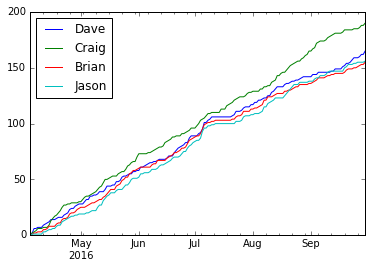

In [14]:
hr_total_frame.plot()

In [15]:
hr_frame.resample('M').sum().transpose()

,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09
Dave,28.0,30.0,31.0,28.0,25.0,23.0
Craig,30.0,40.0,26.0,32.0,37.0,25.0
Brian,24.0,35.0,28.0,26.0,23.0,19.0
Jason,19.0,32.0,32.0,25.0,30.0,18.0


In [16]:
hr_frame.resample('A').sum().transpose()

,2016
Dave,165.0
Craig,190.0
Brian,155.0
Jason,156.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1179a1d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119180790>]], dtype=object)

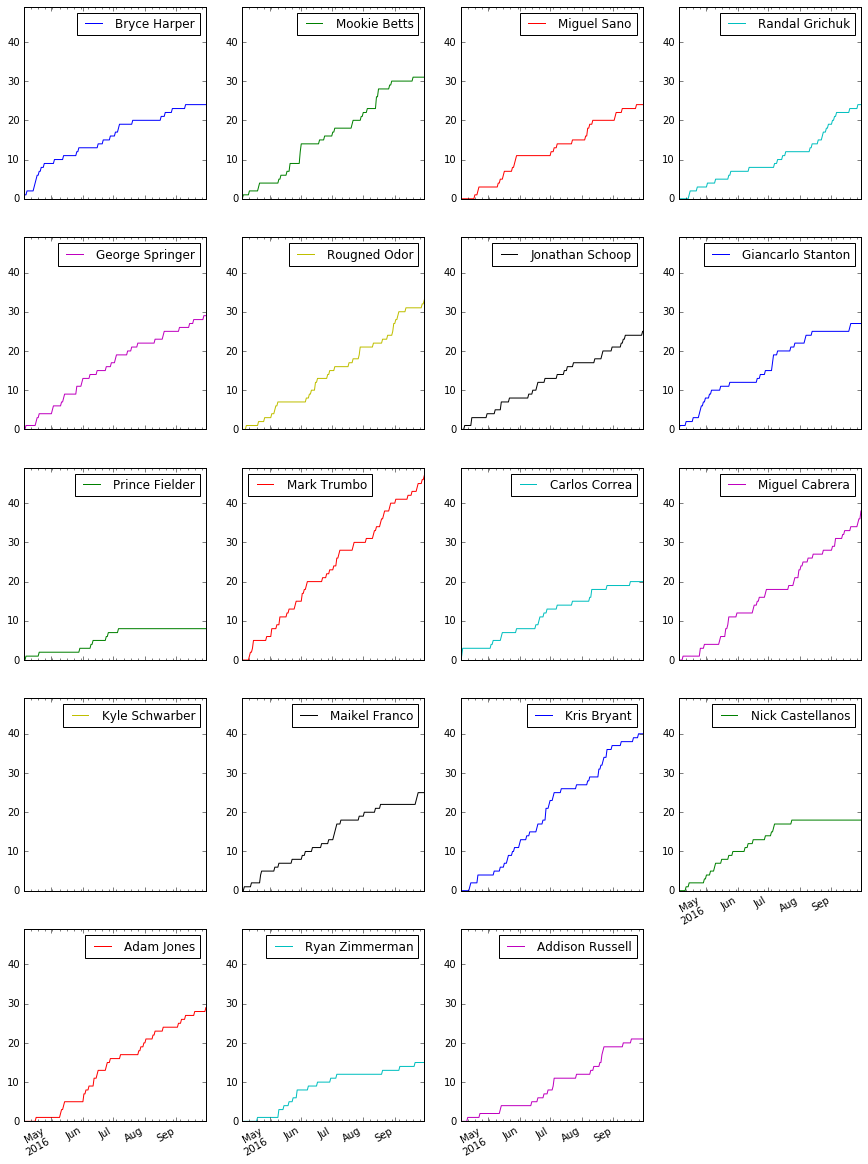

In [17]:
ymax = player_hr_total_df.max().max()

player_hr_total_df.plot(subplots=True, figsize=(15,45), layout=(10, 4), ylim=(0, ymax + 2))


,2016
Dave,165.0
Craig,190.0
Brian,155.0
Jason,156.0


,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09
Dave,28.0,30.0,31.0,28.0,25.0,23.0
Craig,30.0,40.0,26.0,32.0,37.0,25.0
Brian,24.0,35.0,28.0,26.0,23.0,19.0
Jason,19.0,32.0,32.0,25.0,30.0,18.0


,Dave,Craig,Brian,Jason
2016-09-26,159.0,185.0,151.0,155.0
2016-09-27,160.0,186.0,152.0,155.0
2016-09-28,162.0,188.0,153.0,155.0
2016-09-29,162.0,188.0,153.0,155.0
2016-09-30,165.0,190.0,155.0,156.0


,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09
Giancarlo Stanton,8.0,4.0,3.0,7.0,3.0,2.0
Prince Fielder,2.0,1.0,4.0,1.0,0.0,0.0
Mark Trumbo,6.0,9.0,8.0,7.0,10.0,7.0
Carlos Correa,3.0,5.0,5.0,2.0,4.0,1.0
Miguel Cabrera,4.0,8.0,6.0,5.0,5.0,10.0
Kyle Schwarber,0.0,0.0,0.0,0.0,0.0,0.0
Maikel Franco,5.0,3.0,5.0,6.0,3.0,3.0
Total,28.0,30.0,31.0,28.0,25.0,23.0


,2016
Giancarlo Stanton,27.0
Prince Fielder,8.0
Mark Trumbo,47.0
Carlos Correa,20.0
Miguel Cabrera,38.0
Kyle Schwarber,0.0
Maikel Franco,25.0


,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09
Bryce Harper,9.0,4.0,3.0,4.0,3.0,1.0
Mookie Betts,4.0,8.0,4.0,5.0,9.0,1.0
Miguel Sano,3.0,8.0,0.0,4.0,5.0,4.0
Randal Grichuk,3.0,4.0,1.0,4.0,7.0,5.0
George Springer,4.0,8.0,5.0,5.0,3.0,4.0
Rougned Odor,3.0,4.0,8.0,6.0,6.0,6.0
Jonathan Schoop,4.0,4.0,5.0,4.0,4.0,4.0
Total,30.0,40.0,26.0,32.0,37.0,25.0


,2016
Bryce Harper,24.0
Mookie Betts,31.0
Miguel Sano,24.0
Randal Grichuk,24.0
George Springer,29.0
Rougned Odor,33.0
Jonathan Schoop,25.0


,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09
Giancarlo Stanton,8.0,4.0,3.0,7.0,3.0,2.0
Kris Bryant,4.0,7.0,11.0,5.0,10.0,3.0
Prince Fielder,2.0,1.0,4.0,1.0,0.0,0.0
Miguel Sano,3.0,8.0,0.0,4.0,5.0,4.0
Miguel Cabrera,4.0,8.0,6.0,5.0,5.0,10.0
Kyle Schwarber,0.0,0.0,0.0,0.0,0.0,0.0
Nick Castellanos,3.0,7.0,4.0,4.0,0.0,0.0
Total,24.0,35.0,28.0,26.0,23.0,19.0


,2016
Giancarlo Stanton,27.0
Kris Bryant,40.0
Prince Fielder,8.0
Miguel Sano,24.0
Miguel Cabrera,38.0
Kyle Schwarber,0.0
Nick Castellanos,18.0


,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09
Giancarlo Stanton,8.0,4.0,3.0,7.0,3.0,2.0
Adam Jones,1.0,4.0,11.0,4.0,4.0,5.0
Kris Bryant,4.0,7.0,11.0,5.0,10.0,3.0
Miguel Sano,3.0,8.0,0.0,4.0,5.0,4.0
Ryan Zimmerman,1.0,7.0,3.0,1.0,1.0,2.0
Kyle Schwarber,0.0,0.0,0.0,0.0,0.0,0.0
Addison Russell,2.0,2.0,4.0,4.0,7.0,2.0
Total,19.0,32.0,32.0,25.0,30.0,18.0


,2016
Giancarlo Stanton,27.0
Adam Jones,29.0
Kris Bryant,40.0
Miguel Sano,24.0
Ryan Zimmerman,15.0
Kyle Schwarber,0.0
Addison Russell,21.0


,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09
Bryce Harper,9.0,4.0,3.0,4.0,3.0,1.0
Giancarlo Stanton,8.0,4.0,3.0,7.0,3.0,2.0
Mark Trumbo,6.0,9.0,8.0,7.0,10.0,7.0
Maikel Franco,5.0,3.0,5.0,6.0,3.0,3.0
George Springer,4.0,8.0,5.0,5.0,3.0,4.0
Jonathan Schoop,4.0,4.0,5.0,4.0,4.0,4.0
Mookie Betts,4.0,8.0,4.0,5.0,9.0,1.0
Miguel Cabrera,4.0,8.0,6.0,5.0,5.0,10.0
Kris Bryant,4.0,7.0,11.0,5.0,10.0,3.0
Randal Grichuk,3.0,4.0,1.0,4.0,7.0,5.0


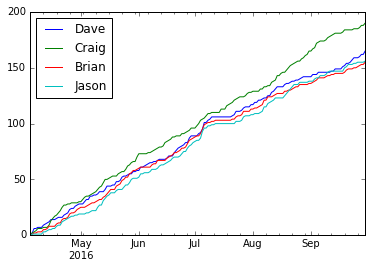

In [18]:
from IPython.display import display, HTML
display(hr_frame.resample('A').sum().transpose())
display(hr_frame.resample('M').sum().transpose())
hr_total_frame.plot()
display(hr_total_frame.tail(5))
for user in users:
    display(HTML("<h2>" + user.name + "</h2>"))
    user_player_frame = user.players_hr_dataframe().resample('M').sum()
    user_player_frame['Total'] = user_player_frame.sum(axis=1)
    display(user_player_frame.transpose())
    display(user.players_hr_dataframe().resample('A').sum().transpose())

display(player_hr_df.resample('M').sum().transpose().sort_values('2016-04', ascending=False))
